In [1]:
import pandas as pd
import numpy as np
import math
import ts_code.nsfg as nsfg
import ts_code.thinkstats2 as thinkstats2
import matplotlib.pyplot as plt
%matplotlib inline

## Chapter 2 - Distributions

One of the best ways to describe a variable is to report the values that appear
in the dataset and how many times each value appears. This description is
called the **distribution** of the variable.

The most common representation of a distribution is a **histogram**, which is a
graph that shows the **frequency** of each value.

Histograms can be represented using a Python dictionary, the counter class or the pandas method **value_counts** which we saw in chapter 1.

In [2]:
preg = nsfg.ReadFemPreg()
#select records for live births
live = preg[preg.outcome == 1]

Let's explore a couple variables that are shown as figures in the book. Avoiding some of the prewritten code, I used the pandas.hist() function.

Thanks to stackoverflow, I was able to figure out that passing range(bins+1) to my bins argument and left to the align paremeter results in the xtick being centered on the bars. This only works for data that you want to essentially bin by integer from it's min to its max.

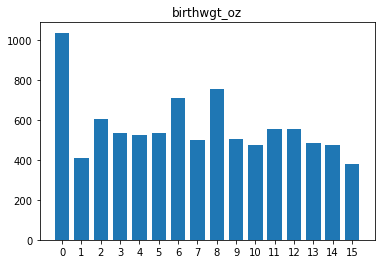

In [3]:
live.hist('birthwgt_oz', grid=False, bins = range(17), rwidth = 0.75, align='left');
plt.xticks(np.arange(16));

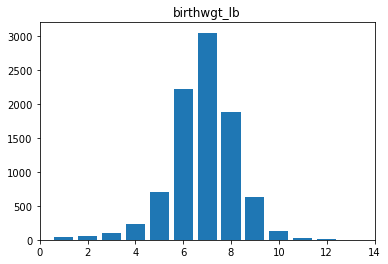

In [4]:
live[live.birthwgt_lb > 0].hist('birthwgt_lb', grid=False, bins = range(14), rwidth = 0.80, align='left')
plt.xlim(0, 14);

Below are a few of the other histograms from the books;

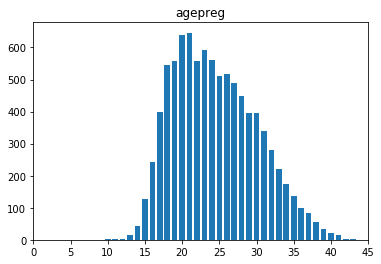

In [5]:
live.hist('agepreg', grid=False, bins = range(45), rwidth = 0.75, align='left')
plt.xlim(0, 45);

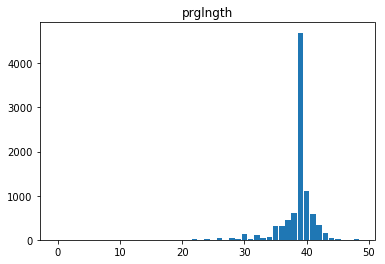

In [6]:
live.hist('prglngth', grid = False, bins = range(50), rwidth = 0.90, align= 'left');

The most common value is called the **mode**. The birth weight in pounds distribution is similar to a **normal distirubtion**, also called a **Guassian distribution**. It's not a true normal distribution though as it has a **tail** that extends farther to the left than to right.

The age at the end of pregnency distribution is also very close to normal.

The birth weight in ounces is a distrubition we would expect to be close to **uniform**, all values have the same frequency. However we see that 0 is more common, likely due to people rounding off birth weights that are close to an integer. 

Histograms are good for identifying some attributes of the data, such as most common values or the shape, but are not always good at making rare values visible.

These rare values are **outliers**, which are extreme values that could be errors, or may actually be records of truly rare events.

One of the easiest ways to do this is to look at the **min and max** of your values.

In [7]:
live['prglngth'].nlargest(10)

4783     50
8998     50
2416     48
4920     48
6889     48
6890     48
7158     48
7161     48
7592     48
11357    47
Name: prglngth, dtype: int64

In [8]:
live['prglngth'].nsmallest(10)

6458      0
4108      4
138       9
11887    13
8919     17
10492    17
541      18
7762     19
1041     20
7800     21
Name: prglngth, dtype: int64

Values below 10 weeks are certainly errors; the most likely explanation is that the outcome was not coded correctly.  Values higher than 30 weeks are probably legitimate. Between 10 and 30 weeks, it is hard to be sure; some values are probably errors, but some represent premature babies.

Most doctors recommend induced labor if a pregnancy exceeds 42 weeks, so some of the longer values are surprising.  In particular, 50 weeks seems medically unlikely.

The best way to handle outliers depends on "domain knowledge"; that is,information about where the data come from and what they mean. It also depends on what analysis you are planning to perform.

In this example, the motivating question is whether first babies tend to be early (or late).  When people ask this question, they are usually interested in full-term pregnancies, so for this analysis we will focus on pregnancies longer than 27 weeks.

The next step would be to compare the distribution of pregnancy lengths for first babies and all other babies.

In [9]:
#divide the dataframe based on birth order
first = live[(live.birthord == 1) & (live.prglngth >= 27) & (live.prglngth <= 45)]
others = live[(live.birthord != 1) & (live.prglngth >= 27) & (live.prglngth <= 45)]

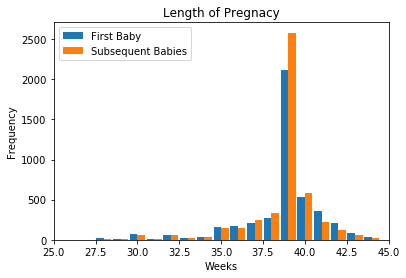

In [10]:
fig, ax = plt.subplots()
ax.hist([first.prglngth, others.prglngth], bins = range(46), histtype="bar", label=("First Baby", "Subsequent Babies"), rwidth = 0.90, align= 'left')
ax.set_xlim(25, 45)
ax.set_title("Length of Pregnacy")
ax.set_xlabel("Weeks")
ax.set_ylabel("Frequency")

ax.legend();

A histogram is a complete description of the distribution, we could reconstruct the values in the sample from it. Often we aren't looking for this level of detail, instead we want to summarize the distribution with a few **descriptive statistics**.

+ **central  tendency:** Do the values tend to cluster around a particular point?

+ **modes:** Is there more than one cluster?

+ **spread:** How much variability is there in the values?

+ **tails:** How quickly do the probabilities drop off as we move away from the modes?

+ **outliers:** Are there extreme values far from the modes?

We use **summary statistics** to describe the data and answer these questions.

The most common summary statistic is the **mean**, which is meant to describe the central tendency of the distribution.

*Def:* For a sample of $n$ values, the mean $\bar{x}$, is the sum of the values ($x_{i}$), divided by the number of values;

$$\bar{x} = \frac{1}{n} \sum_{i} x_{i}$$

The mean is useful when there is a typical object of the set. For example the mean weight of an apple is meaningful because there are not too many outlier apples. Pumpkins on the other hand have a very wide range and can have outliear up to 2,624.6 pounds! If I had grown that pumpkin on a my farm with other "normal" pumkins it would really pull the average weight up. There is no meaningful average in that situation because there is no typical pumpkin. 

We can improve upon these example where there is no typical object by using both the mean and **variance**.

The variance is a summary statistics intended to describe the variability or spread of a distribution.

*Def*: For the set of $n$ values describe in the mean definition;

$$\sigma^{2} = \frac{1}{n} \sum{i}(x_{i}-\bar{x})^{2}$$

This is a sum of the squared deviation from the mean, we are measuring each values distance from the mean, squaring it, and adding them all up.

This is also called the mean squared deviation. The square root of the variance ($\sigma$) is the **standard deviation**.

In [11]:
#mean, variance, and standard deviation with pandas
mean = live.prglngth.mean()
var = live.prglngth.var()
std = live.prglngth.std()
print('Mean: %.02f weeks, Variance: %.02f weeks sq, SD: %.02f weeks' % (mean, var, std))

Mean: 38.56 weeks, Variance: 7.30 weeks sq, SD: 2.70 weeks


Variance is useful in some calculations, but it is not a good summary statistic because it is hard to interpert what 7.3 weeks squared really means. It is much easier to see that the average length is 38.56 weeks and this deviates by 2-3 weeks.

An **effect size** is a summary statistic intended to describe the size of an effect. Describing the difference between two groups could be done by comparising their means. In our first birth example the mean for first babies is 38.601 and for other it is 38.523, a difference of 0.078 weeks or 0.2% of a typical pregnency.

If we assume this is correct, such a difference would have no consquence. Without observing a large number of pregnancies it is unlikely anyone would notice this difference at all.

Another approach is to compare the *difference between* groups to the *variability within* groups. **Cohen's d** is intended to just that.

*Def:*
$$d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s}$$

where, $\bar{x}_{1}$ and $\bar{x}_{2}$ are the means of the two groups and $s$ is the "pooled standard deviation". This pooled standard deviation is the sum of each variance, multiplied by it's group's number of values, then divided by the total values in each group $\frac{(n_{1} \cdot \sigma^{2}_{1} + n_{2} \cdot \sigma^{2}_{2})}{(n_{1} + n_{2})}$.

In [12]:
#I thought there would be built in cohen d function, but a quick search did not return one
#it's easy enough to put together though

def CohenD(group1, group2):
    diff = group1.mean() - group2.mean()
    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / math.sqrt(pooled_var)
    return d

In [13]:
CohenD(first.prglngth, others.prglngth) #this is an extremely small effect size

0.02847218973825238

### Exercises

**Exercise 2.1** Based on the results in this chapter, suppose you were asked to summarize what you learned about whether first babies arrive late.

> There is no evidence to suggest that first babies arrive late. The Cohen's d score between the two groups is only 0.02, showing a the very small effect that birth order has on the length of the pregnancy.

Which summary statistics would you use if you wanted to get a story on the evening news? Which ones would you use if you wanted to reassure an anxious patient?

> I'm not sure any of these statistics jump out as newsworthy, maybe that there are 329 less first babies born after 38 weeks than other babies? 

>I'm not sure what the patient is anxious about, is it that they think this pregnency will be longer than average because it's a first or other baby? The difference between two on average is a few hours, so the length of their pregnency is not going to depend on whether this is their first or seventh child.

Finally, imagine that you are Cecil Adams, author of The Straight Dope (http://straightdope.com), and your job is to answer the question, "Do first babies arrive late?" Write a paragraph that uses the results in this chapter to answer the question clearly, precisely, and honestly.

> The answer, simply put, is no. Obviously this depends on what we call late, are we saying birth in week 40 is late, week 41, 42? Let's start with average first and average "other" baby, first babies arrive about 13 hours or .02% of a pregnancy later than the other babies group. This is an exremely small amount of time in grand scheme of a pregnancy. In fact, the Cohen's d value (used to measure effect size between two group) is only 0.02847, suggesting that birth order has a very small effect on the length of the pregnancy. 

>Now if we want to start defining late to mean after a certain point, then this question becomes a little more interesting. Let's say 41 weeks and later is late, doctors tend to induce at 42 weeks, and we have cut off any truly rare values above 45 from out data. Well, then 9% of other babies go to 41 weeks and beyond, but 15% of first babies do. For 42+ weeks, this becomes 4% and 7%, 1.8% and 2.6% for 43+ weeks, and finally 0.5% and 0.6% for 44+ weeks. This would suggested that while on average first babies arrive in the same amount of time as every other baby, they actually have a slightly better chance of arriving late!

In [14]:
print(len(others[others.prglngth >= 41].prglngth)/len(others.prglngth))
len(first[first.prglngth >= 41].prglngth)/len(first.prglngth)

0.09337028352163718


0.15562157221206582

**Exercise 2.2** In the repository you downloaded, you should find a file named chap02ex.ipynb; open it. Some cells are already filled in, and you should execute them. Other cells give you instructions for exercises. Follow the instructions and fill in the answers.

**Exercise 2.3** The mode of a distribution is the most frequent value. Write a function called *Mode* that takes a Hist and returns the most frequent value. 

As a more challenging exercise, write a function called *AllModes* that returns a list of value-frequency pairs in descending order of frequency.

>Done with Pandas, seems more practical

In [15]:
first.prglngth.mode()[0]

39

In [16]:
first.prglngth.value_counts().sort_values(ascending = False)

39    2114
40     536
41     360
38     272
37     208
42     205
36     172
35     159
43      87
30      73
32      55
34      29
33      28
28      24
44      23
31      15
29       9
45       6
27       1
Name: prglngth, dtype: int64

**Exercise 2.4** Using the variable totalwgt_lb, investigate whether first babies are lighter or heavier than others. Compute Cohen's d to quantify the difference between the groups. How does it  compare to the difference in pregnancy length?

In [17]:
CohenD(first.totalwgt_lb, others.totalwgt_lb)

-0.08863772690516286

>First babies tend to be a little bit lighter than other babies, resulting in a negative Cohen's d value. The effect measure is a bit bigger than the value measure for pregnancy lengths, but still fairly small.

###  Glossary

**distribution:** The values that appear in a sample and the frequency of each.

**histogram:** A mapping from values to frequencies, or a graph that shows this mapping.

**frequency:** The number of times a value appears in a sample.

**mode:** The most frequent value in a sample, or one of the most frequent values.

**normal distribution:** An idealization of a bell-shaped distribution; also known as a Gaussian distribution.

**uniform distribution:** A distribution in which all values have the same frequency.

**tail:** The part of a distribution at the high and low extremes.\

**central tendency:** A characteristic of a sample or population; intuitively, it is an average or typical value.

**outlier:** A value far from the central tendency.

**spread:** A measure of how spread out the values in a distribution are.

**summary statistic:** A statistic that quantifies some aspect of a distribution, like central tendency or spread.

**variance:** A summary statistic often used to quantify spread.

**standard deviation:** The square root of variance, also used as a measure of spread.


**effect size:** A summary statistic intended to quantify the size of an effect like a difference between groups.

**clinically signiffcant:** A result, like a difference between groups, that is relevant in practice.